# Simultaneous diagnosis
Simultaneous classification, localization, and characterization with one of two methods:
- L2-norm approaches, either distance or Bayesian.
- Transfer function approach.

In [2]:
# Library imports.
import copy
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import pandas as pd
from pathlib import Path
import scipy

# Urbansurge imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.fault_diagnosis import distance_diagnosis, data_utils, residual_detection, moment_detection
from urbansurge.fault_diagnosis.accuracy_metrics import true_positive_rate

# Autoreload.
%load_ext autoreload
%autoreload 2

In [3]:
# SWMM model configuration file path.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Node where impulse is added.
input_node = 18

# Physical model fault database path.
phy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_fault_database.csv"

# Simulation model fault database path.
sim_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_impulse_fault_database.csv"

# Physical model with no faults (i.e., "healthy" case)
phy_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_healthy_impulse_database.csv"

# Simulation model with no faults (i.e., "healthy" case)
sim_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_healthy_impulse_database.csv"

# Figure save path.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Manuscript\manuscript-v1\Figures')

In [4]:
# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


In [5]:
# Physical system fault database.
phy_db = pd.read_csv(phy_save_fp)

# # Simulation system fault database.
# sim_db = pd.read_csv(phy_save_fp)

# Physical healthy system run.
phy_healthy_db = pd.read_csv(phy_healthy_save_fp)

# # Simulated healthy system run.
# sim_healthy_db = pd.read_csv(phy_healthy_save_fp)

In [6]:
# Remove roughness faults.
phy_db = phy_db.loc[phy_db['fault_type']!='roughness', :].reset_index(drop=True)

## Fault severity vs. sensor density

In [7]:
# Depth and velocity columns.
dep_vel_cols = [s for s in phy_healthy_db if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
links = [20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
skips = [1, 2, 3, 4, 5, 10]

In [8]:
import itertools

# Example list
s = links[1:]

# Length of the list
n = len(s)

# Dictionary to store combinations
combinations_dict = {}

# Add single outfall.
combinations_dict[1] = [[20]]

# Loop through each length k from 1 to n
for k in range(1, n + 1):
    # Generate all combinations of length k
    combinations = list(itertools.combinations(s, k))
    # Store in the dictionary and add outfall.
    combinations_dict[k + 1] = [list(i) + [links[0]] for i in combinations]

# Sensor combinations dictionary.
sensor_combinations = combinations_dict

# Number of sensor combinations at each sensor density.
n_combo = {}
for k, v in sensor_combinations.items():
    n_combo[k] = len(v)

## Fault severity vs. measurement noise

In [15]:
# Define relative measurement error as a fraction.
noise_rel_error = np.linspace(0, 15, 30) / 100
noise_scale = np.linspace(0, 0.2, 30)

# Relative noise.
relative_noise = True

if relative_noise is True:
    depth_noise_scale = noise_scale
    velocity_noise_scale = noise_scale
else:
    # Define absolute measurement noise scale as a fraction of the maximum depth in the outfall link reached under the healthy case.
    max_depth = np.max(phy_healthy_db['Depth_link_20'])
    depth_noise_scale = noise_scale * max_depth

    # Scale of velocity noise.
    max_velocity = np.max(phy_healthy_db['Velocity_link_20'])
    velocity_noise_scale = noise_scale * max_velocity

# Clipping hours.
clip_hours = 6

In [16]:
# Fault types.
fault_types = np.unique(phy_db.fault_type)

# # Severity density arrays for storing diagnosis accuracy metrics.
# severity_density_arrays = {}
severity_dict = {}
for fault_type in fault_types:
    # Severity levels.
    severity_levels = np.unique(phy_db.loc[phy_db.fault_type==fault_type, 'fault_value'])
    severity_dict[fault_type] = severity_levels

#     severity_density_ar = np.zeros((len(severity_levels), len(skips)))
#     severity_density_arrays[fault_type] = severity_density_ar
#     print(severity_density_ar.shape)
    
# Scenarios.
scenarios = np.unique(phy_db.scenario)
scenario_fault_types = [phy_db.loc[phy_db.scenario==scenario, 'fault_type'].iloc[0] for scenario in scenarios]
scenario_fault_types = np.array(scenario_fault_types)
scenario_severities = [phy_db.loc[phy_db.scenario==scenario, 'fault_value'].iloc[0] for scenario in scenarios]
scenario_severities = np.array(scenario_severities)

# Distance upstream to each component.
distance_dict = {
    'fault_type': [],
    'fault_component': [],
    'upstream_distance': []
}

# Fault component types.
fault_type_component = {'diameter': 'Link', 'roughness': 'Link', 'silting': 'Junction'}

# Loop through fault components and populate the dictionary.
type_component_df = phy_db[['fault_type', 'fault_component']].drop_duplicates()
type_component_df.reset_index(inplace=True, drop=True)
for i in range(type_component_df.shape[0]):
    component_class = type_component_df.loc[i, 'fault_type']
    component = type_component_df.loc[i, 'fault_component']
    up_dist = swmm.upstream_distance(20, 'Link', component, fault_type_component[component_class])
    distance_dict['fault_type'].append(component_class)
    distance_dict['fault_component'].append(component)
    distance_dict['upstream_distance'].append(up_dist)

# Create data frame from distance dictionary.
distance_df = pd.DataFrame(distance_dict)
print(distance_df.head())

  fault_type  fault_component  upstream_distance
0   diameter               76                5.0
1   diameter               77             2025.0
2   diameter               78             1520.0
3   diameter               79             1015.0
4   diameter               80              510.0


### Detection and Diagnosis

In [13]:
# Dignosis model to use.
diagnosis_model = 'distance'

# Sensor columns.
sensor_links = [20]
dep_cols = [f'Depth_link_{s}' for s in sensor_links]
vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
dep_vel_cols = dep_cols + vel_cols

# Number of test samples.
n_test_samp = 10

# Scenarios. 
scenarios = np.unique(phy_db['scenario'])

# Diagnosis model.
model_D = distance_diagnosis.DistanceDiagnoser()

#### Pre-processing.
# Clipping data frames.
phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False)

#### Train model with fault database ####
# Loop through scenarios.
X_train = np.zeros((len(scenarios), phy_healthy_db_clip.shape[0]))
y_train = np.zeros((len(scenarios), phy_healthy_db_clip.shape[0]))
for i, scenario in enumerate(scenarios):
    # Depth and velocity from database.
    db_depth = phy_db_clip.loc[phy_db['scenario']==scenario, dep_cols].to_numpy()
    db_velocity = phy_db_clip.loc[phy_db['scenario']==scenario, vel_cols].to_numpy()

    # Get area time series.
    if len(dep_cols) > 1:
        raise ValueError('Current implmentation only works for single sensor.')
    link_id = dep_cols[0].split('_')[-1] # Using the only sensor listed in depth columns.
    db_area = swmm.compute_area_from_depth(db_depth, link_id)

    # Compute flow rate.
    db_flow = db_velocity * db_area

    # Add to training array.
    X_train[i,:] = db_flow.flatten()

# Prepare labels.
_, y_train = data_utils.prepare_states(phy_db_clip, dep_vel_cols)

# Fit diagnosis model.
model_D.fit_model(X_train, y_train)


In [ ]:
# #### Generate baseline samples. ####
# n_samples = 10 # Number of times the baseline system is sampled.

# # Time steps.
# dt = list(phy_healthy_db_clip['datetime'] - timedelta(minutes=1))

# # Depth baseline observations.
# d_obs_baseline, d_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_cols, 
#                                                                             n_samples, depth_noise_scale[noise_idx], relative_noise=relative_noise)
# d_obs_baseline = np.moveaxis(d_obs_baseline, 2, 0)
# d_obs_baseline[d_obs_baseline < 0] = 0 # Depth cannot be negative.
# print('Depth baseline observations shape', d_obs_baseline.shape)

# # Depth baseline observations.
# v_obs_baseline, v_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, vel_cols, 
#                                                                             n_samples, velocity_noise_scale[noise_idx], relative_noise=relative_noise)
# v_obs_baseline = np.moveaxis(v_obs_baseline, 2, 0)
# v_obs_baseline[v_obs_baseline < 0] = 0
# print('Velocity baseline observations shape', v_obs_baseline.shape)

# # Wetted area for observed baseline.
# area_obs_baseline = np.zeros_like(d_obs_baseline)
# for id, dep_col in enumerate(dep_cols):
#     link_id = dep_col.split('_')[-1]
#     area_obs_baseline[:,:,id] = swmm.compute_area_from_depth(d_obs_baseline[:,:,id], link_id)
    
# # Compute flow rate Q.
# Q_obs_baseline = v_obs_baseline * area_obs_baseline

NameError: name 'noise_idx' is not defined

In [18]:
diagnosis_dict = {
    'true_scenario': [],
    'noise_level': [],
    'true_fault_type': [],
    'true_fault_component': [],
    'true_fault_distance': [],
    'true_fault_value': [],
    'sample_no': [],
    'predict_fault_type': [],
    'predict_fault_component': [],
    'predict_fault_distance': [],
    'predict_fault_value': [],
    'predict_scenario': [],
    'ens_predict_fault_type': [],
    'ens_predict_fault_component': [],
    'ens_predict_fault_distance': [],
    'ens_predict_fault_value': [],
    'ens_predict_scenario': [],
    'ens_classification': [],
    'detection': [],
    'welch_detect': [],
    'classification': [],
}

#### Fault diagnosis loop ####
for noise_idx in range(len(noise_scale)):
# for noise_idx in [15]:
    print('Noise index:', noise_idx)

    #### Generate baseline samples. ####
    n_samples = 10 # Number of times the baseline system is sampled.

    # Time steps.
    dt = list(phy_healthy_db_clip['datetime'] - timedelta(minutes=1))

    # Depth baseline observations.
    d_obs_baseline, d_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_cols, 
                                                                                n_samples, depth_noise_scale[noise_idx], relative_noise=relative_noise)
    d_obs_baseline = np.moveaxis(d_obs_baseline, 2, 0)
    d_obs_baseline[d_obs_baseline < 0] = 0 # Depth cannot be negative.
    print('Depth baseline observations shape', d_obs_baseline.shape)

    # Depth baseline observations.
    v_obs_baseline, v_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, vel_cols, 
                                                                                n_samples, velocity_noise_scale[noise_idx], relative_noise=relative_noise)
    v_obs_baseline = np.moveaxis(v_obs_baseline, 2, 0)
    v_obs_baseline[v_obs_baseline < 0] = 0
    print('Velocity baseline observations shape', v_obs_baseline.shape)

    # Wetted area for observed baseline.
    area_obs_baseline = np.zeros_like(d_obs_baseline)
    for id, dep_col in enumerate(dep_cols):
        link_id = dep_col.split('_')[-1]
        area_obs_baseline[:,:,id] = swmm.compute_area_from_depth(d_obs_baseline[:,:,id], link_id)
        
    # Compute flow rate Q.
    Q_obs_baseline = v_obs_baseline * area_obs_baseline

    # Loop through scenarios.
    for i, scenario in enumerate(scenarios):
        # True fault characteristics.
        true_fault_type = phy_db_clip.loc[phy_db['scenario']==scenario, 'fault_type'].iloc[0]
        true_fault_component = phy_db_clip.loc[phy_db['scenario']==scenario, 'fault_component'].iloc[0]
        true_fault_value = phy_db_clip.loc[phy_db['scenario']==scenario, 'fault_value'].iloc[0]
        true_fault_distance = distance_df.loc[(distance_df['fault_type']==true_fault_type) & (distance_df['fault_component']==true_fault_component), 'upstream_distance'].iloc[0]

        # Depth and velocity test samples.
        test_depth_scenario = phy_db_clip.loc[phy_db['scenario']==scenario, dep_cols].to_numpy()
        test_velocity_scenario = phy_db_clip.loc[phy_db['scenario']==scenario, vel_cols].to_numpy()
        
        # TESTING: only process a certain type of fault.
        # if true_fault_type == 'diameter' or true_fault_value < 0.5:
        #     continue

        # Loop through test samples.
        y_obs = np.zeros((n_test_samp, test_velocity_scenario.shape[0]))
        for j in range(n_test_samp):
            # Add noise to test sample.
            # noise_depth = np.random.normal(0, depth_noise_scale[noise_idx] * np.max(test_depth_scenario), size=test_depth_scenario.shape)
            # noise_velocity = np.random.normal(0, velocity_noise_scale[noise_idx] * np.max(test_velocity_scenario), size=test_depth_scenario.shape)
            noise_depth = np.random.normal(0, depth_noise_scale[noise_idx] * test_depth_scenario)
            noise_velocity = np.random.normal(0, velocity_noise_scale[noise_idx] * test_velocity_scenario)
            test_depth = test_depth_scenario + noise_depth
            test_velocity = test_velocity_scenario +  noise_velocity

            # Remove values less than 0.
            test_depth[test_depth < 0] = 0
            test_velocity[test_velocity < 0] = 0

            # Get area time series.
            if len(dep_cols) > 1:
                raise ValueError('Current implmentation only works for single sensor.')
            link_id = dep_cols[0].split('_')[-1] # Using the only sensor listed in depth columns.
            test_area = swmm.compute_area_from_depth(test_depth, link_id)

            # Compute flow rate.
            test_flow = test_velocity * test_area
            y_obs[j,:] = test_flow.flatten()

            # TESTING: Plotting baseline vs. observed.
            # if true_fault_type == 'silting':
            #     fig, ax = plt.subplots()
            #     ax.plot(np.squeeze(Q_obs_baseline[:,:100,:]).T, 'k')
            #     ax.plot(test_flow[:100])
            #     # raise

            #### Detection ####
            # If y_obs is completely zero and the baseline observation is not completely zero, then a fault has occurred.
            if np.sum(test_flow) == 0 and np.sum(Q_obs_baseline) != 0:
                detect = True
            else:
                detect = moment_detection.moment_fault_detect(dt, Q_obs_baseline, test_flow.reshape(-1,1)[:,0])

            #### Diagnosis ####
            # Find best match from fault database.
            pred_df = model_D.predict(test_flow.reshape(1,-1), n_l2=1) 

            predicted_fault_type = pred_df.loc[0, 'fault_type']
            predicted_fault_component = pred_df.loc[0, 'fault_component']
            predicted_fault_value = pred_df.loc[0, 'fault_value']
            predicted_fault_distance = distance_df.loc[(distance_df['fault_type']==predicted_fault_type) & (distance_df['fault_component']==predicted_fault_component), 'upstream_distance'].iloc[0]
            predicted_scenario = pred_df.loc[0, 'scenario']

            #### Save results to diagnosis dictionary ####
            diagnosis_dict['true_scenario'].append(scenario)
            diagnosis_dict['noise_level'].append(noise_scale[noise_idx])
            diagnosis_dict['true_fault_type'].append(true_fault_type)
            diagnosis_dict['true_fault_component'].append(true_fault_component)
            diagnosis_dict['true_fault_distance'].append(true_fault_distance)
            diagnosis_dict['true_fault_value'].append(true_fault_value)
            diagnosis_dict['sample_no'].append(j + 1)
            diagnosis_dict['predict_fault_type'].append(predicted_fault_type)
            diagnosis_dict['predict_fault_component'].append(predicted_fault_component)
            diagnosis_dict['predict_fault_distance'].append(predicted_fault_distance)
            diagnosis_dict['predict_fault_value'].append(predicted_fault_value)
            diagnosis_dict['predict_scenario'].append(predicted_scenario)
            diagnosis_dict['detection'].append(detect)
            diagnosis_dict['classification'].append(true_fault_type == predicted_fault_type)

        # Find best match from fault database.
        pred_df = model_D.predict(np.mean(y_obs, axis=0).reshape(1,-1), n_l2=1) 

        predicted_fault_type = pred_df.loc[0, 'fault_type']
        predicted_fault_component = pred_df.loc[0, 'fault_component']
        predicted_fault_value = pred_df.loc[0, 'fault_value']
        predicted_fault_distance = distance_df.loc[(distance_df['fault_type']==predicted_fault_type) & (distance_df['fault_component']==predicted_fault_component), 'upstream_distance'].iloc[0]
        predicted_scenario = pred_df.loc[0, 'scenario']
        ens_classification = predicted_fault_type == true_fault_type

        diagnosis_dict['ens_predict_fault_type'].extend([predicted_fault_type for i in range(n_test_samp)])
        diagnosis_dict['ens_predict_fault_component'].extend([predicted_fault_component for i in range(n_test_samp)])
        diagnosis_dict['ens_predict_fault_distance'].extend([predicted_fault_distance for i in range(n_test_samp)])
        diagnosis_dict['ens_predict_fault_value'].extend([predicted_fault_value for i in range(n_test_samp)])
        diagnosis_dict['ens_predict_scenario'].extend([predicted_scenario for i in range(n_test_samp)])
        diagnosis_dict['ens_classification'].extend([ens_classification for i in range(n_test_samp)])

        detect = moment_detection.moment_welch_test(dt, Q_obs_baseline, y_obs)
        diagnosis_dict['welch_detect'].extend([detect for i in range(n_test_samp)])
    #     break
    # break
diagnosis_df = pd.DataFrame(diagnosis_dict)
diagnosis_df.head(10)

Noise index: 0
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-pack

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


NO FLOW OBSERVED >>> Declaring fault


c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-pack

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due t

Noise index: 1
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 2
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 3
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 4
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 5
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 6
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 7
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 8
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 9
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 10
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 11
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 12
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 13
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 14
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 15
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 16
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 17
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 18
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 19
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 20
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 21
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 22
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 23
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 24
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 25
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 26
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 27
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
Noise index: 28
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault
Noise index: 29
Depth baseline observations shape (10, 360, 1)
Velocity baseline observations shape (10, 360, 1)


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]


NO FLOW OBSERVED >>> Declaring fault


C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y_obs_sensor) / m0_obs[i]
C:\Users\ay434\Documents\urbansurge\src\urbansurge\fault_diagnosis\moment_detection.py:177: RuntimeWarning: invalid value encountered in scalar divide
  m1_obs[i] = np.sum(t_hr * y

NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault
NO FLOW OBSERVED >>> Declaring fault


,true_scenario,noise_level,true_fault_type,true_fault_component,true_fault_distance,true_fault_value,sample_no,predict_fault_type,predict_fault_component,predict_fault_distance,...,predict_scenario,ens_predict_fault_type,ens_predict_fault_component,ens_predict_fault_distance,ens_predict_fault_value,ens_predict_scenario,ens_classification,detection,welch_detect,classification
0,0,0.0,diameter,76,5.0,0.0,1,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
1,0,0.0,diameter,76,5.0,0.0,2,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
2,0,0.0,diameter,76,5.0,0.0,3,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
3,0,0.0,diameter,76,5.0,0.0,4,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
4,0,0.0,diameter,76,5.0,0.0,5,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
5,0,0.0,diameter,76,5.0,0.0,6,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
6,0,0.0,diameter,76,5.0,0.0,7,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
7,0,0.0,diameter,76,5.0,0.0,8,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
8,0,0.0,diameter,76,5.0,0.0,9,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True
9,0,0.0,diameter,76,5.0,0.0,10,diameter,76,5.0,...,0,diameter,76,5.0,0.0,0,True,False,0,True


In [62]:
print(diagnosis_dict['ens_predict_fault_type'])

['diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'diameter', 'di

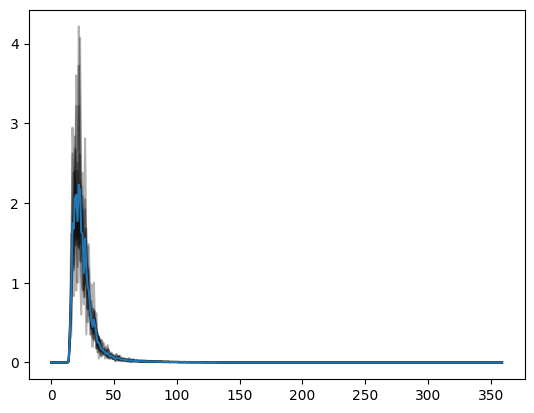

In [159]:
plt.plot(y_obs.T, 'k', alpha=0.3)
plt.plot(np.mean(y_obs, axis=0))
plt.show()

In [33]:
print(diagnosis_df.shape)
print(len(scenarios))

(90000, 15)
300


In [19]:
# Add experiment signifier.
experiment = np.repeat(np.arange(diagnosis_df.shape[0] / 10), 10)
diagnosis_df['experiment'] = experiment

#### Mode of distance and severity

In [20]:
# Loop through scenarios and get the model of the distance and severity. Compare to true location and severity.
results_dict = {
    'noise_level': [],
    'experiment': [],
    'true_fault_type': [],
    'true_distance': [],
    'distance_mode': [],
    'distance_diff': [],
    'true_severity': [],
    'severity_mode': [],
    'severity_diff': [],
    'classification': [],
    'detection': [],
    'detection_welch': []
}

for i in np.unique(diagnosis_df['experiment']):
    # Select the true scenario.
    true_scenario_df = diagnosis_df.iloc[10 * int(i):10 * int(i) + 10, :]
    true_distance = true_scenario_df['true_fault_distance'].iloc[0] 
    true_value = true_scenario_df['true_fault_value'].iloc[0]
    # distance_mode = scipy.stats.mode(true_scenario_df['predict_fault_distance'].to_numpy()).mode
    # severity_mode = scipy.stats.mode(true_scenario_df['predict_fault_value'].to_numpy()).mode
    # classification_mode = scipy.stats.mode(true_scenario_df['classification'].to_numpy().astype(int)).mode
    detection_mode = scipy.stats.mode(true_scenario_df['detection'].to_numpy().astype(int)).mode

    # Ensembled values.
    distance_mode = true_scenario_df['ens_predict_fault_distance'].to_numpy()[0]
    severity_mode = true_scenario_df['ens_predict_fault_value'].to_numpy()[0]
    classification_mode = true_scenario_df['ens_classification'].to_numpy()[0]
    
    # Populate results dictionary.
    results_dict['experiment'].append(i)
    results_dict['noise_level'].append(true_scenario_df['noise_level'].iloc[0])
    results_dict['true_fault_type'].append(true_scenario_df['true_fault_type'].iloc[0])
    results_dict['true_distance'].append(true_distance)
    results_dict['true_severity'].append(true_value)
    results_dict['distance_mode'].append(distance_mode)
    results_dict['distance_diff'].append(np.abs(distance_mode - true_distance))
    results_dict['severity_mode'].append(severity_mode)
    results_dict['severity_diff'].append(np.abs(severity_mode - true_value))
    results_dict['classification'].append(classification_mode)
    results_dict['detection'].append(detection_mode)
    results_dict['detection_welch'].append(true_scenario_df['welch_detect'].to_numpy()[0])

results_df = pd.DataFrame(results_dict)


### False positive rate

In [67]:
# False detection rate.
FP = np.zeros(len(noise_scale))

# Number of repetitions.
n_rep = 100

for noise_idx in range(len(noise_scale)):
# for noise_idx in [3]:
    print('NOISE SCALE', noise_idx)

    # Sensor columns.
    sensor_links = [20]
    # print(sensor_links)
    dep_cols = [f'Depth_link_{s}' for s in sensor_links]
    vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
    dep_vel_cols = dep_cols + vel_cols

    # Loop for false positives. Total number of false positives out of number of iterations is FPR.
    for i in range(n_rep):
        # Baseline observations and ensemble from multiple samples.
        n_samples = 10 # Number of times the baseline system is sampled. Must be even number.

        # Depth baseline observations.
        d_obs_baseline, d_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_cols, 
                                                                                    n_samples, depth_noise_scale[noise_idx], relative_noise=relative_noise)
        d_obs_baseline = np.moveaxis(d_obs_baseline, 2, 0)
        d_obs_baseline[d_obs_baseline < 0] = 0 # Depth cannot be negative.
        # print('Depth baseline observations shape', d_obs_baseline.shape)

        # Depth baseline observations.
        v_obs_baseline, v_baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, vel_cols, 
                                                                                    n_samples, velocity_noise_scale[noise_idx], relative_noise=relative_noise)
        v_obs_baseline = np.moveaxis(v_obs_baseline, 2, 0)
        v_obs_baseline[v_obs_baseline < 0] = 0
        # print('Velocity baseline observations shape', v_obs_baseline.shape)

        # Wetted area for observed baseline.
        area_obs_baseline = np.zeros_like(d_obs_baseline)
        for id, dep_col in enumerate(dep_cols):
            link_id = dep_col.split('_')[-1]
            area_obs_baseline[:,:,id] = swmm.compute_area_from_depth(d_obs_baseline[:,:,id], link_id)
            
        # Compute flow rate Q.
        Q_obs_baseline = v_obs_baseline * area_obs_baseline

        # Retain ten samples as the test sample.
        Q_obs_test = np.squeeze(Q_obs_baseline[:int(n_samples / 2),:,:]).T

        # Remaining points as baseline samples.
        Q_obs_baseline = Q_obs_baseline[int(n_samples / 2):,:,:]

        # Fault detection.
        # -------------------------------------------------
        # Observed time series. From dimension (Nt, Nsensor, 1) to (Nsensor, Nt)
        # y_obs = np.squeeze(Qphy[:,:,i]).T 

        # # Range detection.
        # detection_array = np.zeros(10)
        # for j in range(10):
        #     # Detection.
        #     # detect = residual_detection.residual_fault_detect(d_obs_baseline, y_obs, significance=0.01, test_type='noise_floor')
        #     dt = list(phy_healthy_db_clip['datetime'] - timedelta(minutes=1))

        #     # If y_obs is completely zero and the baseline observation is not completely zero, then a fault has occurred.
        #     if np.sum(Q_obs_test) == 0 and np.sum(Q_obs_baseline) != 0:
        #         detect = True
        #     else:
        #         detect = moment_detection.moment_fault_detect(dt, Q_obs_baseline, Q_obs_test[:,j])

        #     detection_array[j] = detect

        # mode_detection = scipy.stats.mode(detection_array.astype(int)).mode

        # Welch t-test.
        mode_detection = moment_detection.moment_welch_test(dt, Q_obs_baseline, Q_obs_test.T)

        FP[noise_idx] += mode_detection 

# Normalize by the number of samples.
FP_norm = FP / n_rep

NOISE SCALE 0


c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\ay434\Desktop\Python\urbansurge-env\lib\site-pack

NOISE SCALE 1
NOISE SCALE 2
NOISE SCALE 3
NOISE SCALE 4
NOISE SCALE 5
NOISE SCALE 6
NOISE SCALE 7
NOISE SCALE 8
NOISE SCALE 9
NOISE SCALE 10
NOISE SCALE 11
NOISE SCALE 12
NOISE SCALE 13
NOISE SCALE 14
NOISE SCALE 15
NOISE SCALE 16
NOISE SCALE 17
NOISE SCALE 18
NOISE SCALE 19
NOISE SCALE 20
NOISE SCALE 21
NOISE SCALE 22
NOISE SCALE 23
NOISE SCALE 24
NOISE SCALE 25
NOISE SCALE 26
NOISE SCALE 27
NOISE SCALE 28
NOISE SCALE 29


(5, 360, 1)
(360, 5)


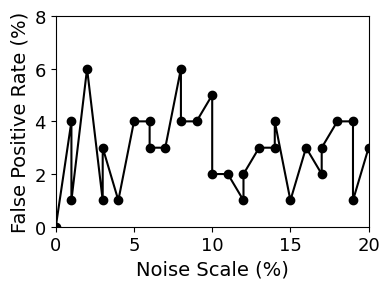

In [153]:
print(Q_obs_baseline.shape)
print(Q_obs_test.shape)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot([round(nr) for nr in noise_scale * 100], FP_norm * 100, 'k-o')
ax.tick_params(labelsize=13)
ax.set_ylim([0, 8])
ax.set_xlim([0, 20])
ax.set_xlabel('Noise Scale (%)', fontsize=14)
ax.set_ylabel('False Positive Rate (%)', fontsize=14)

fig.tight_layout()
fig.savefig(fig_savefp / 'FPR_sensors.png', dpi=300)


In [21]:
# Arrays to store fault data.
# fault_array_dict = {
#     'diameter': np.zeros((len(severity_dict['diameter']), len(noise_scale))), 
#     'roughness': np.zeros((len(severity_dict['roughness']), len(noise_scale))),
#     'silting': np.zeros((len(severity_dict['silting']), len(noise_scale)))
# }

fault_array_dict = {
    'diameter': np.zeros((len(severity_dict['diameter']), len(noise_scale))), 
    'silting': np.zeros((len(severity_dict['silting']), len(noise_scale)))
}

severity_density_dict = {
    'detection': copy.deepcopy(fault_array_dict),
    'classification': copy.deepcopy(fault_array_dict),
    'localization': copy.deepcopy(fault_array_dict),
    'characterization': copy.deepcopy(fault_array_dict),
    'scenario_order': copy.deepcopy(fault_array_dict)
}

# error_groups = error_df.groupby(['fault_class', 'fault_severity', 'measurement_error'])
error_groups = results_df.groupby(['true_fault_type', 'true_severity', 'noise_level'])
for name, group in error_groups:
    print(name)
    fault_type = name[0]
    severity = name[1]
    measurement_error = name[2]
    severity_idx = np.where(severity_dict[fault_type] == severity)[0][0]
    error_idx = np.where(noise_scale == measurement_error)[0][0]
    
    # Detection.
    print(group['detection_welch'])
    detection = np.nanmean(group['detection_welch'])
    severity_density_dict['detection'][fault_type][severity_idx, error_idx] = detection

    if np.all(group['detection_welch'] == 0):
        severity_density_dict['classification'][fault_type][severity_idx, error_idx] = np.nan
        severity_density_dict['localization'][fault_type][severity_idx, error_idx] = np.nan
        severity_density_dict['characterization'][fault_type][severity_idx, error_idx] = np.nan
    else:
        severity_density_dict['classification'][fault_type][severity_idx, error_idx] = np.nanmean(group['classification'])
        severity_density_dict['localization'][fault_type][severity_idx, error_idx] = np.nanmean(group['distance_diff'])
        severity_density_dict['characterization'][fault_type][severity_idx, error_idx] = np.nanmean(group['severity_diff'])

('diameter', 0.0, 0.0)
0      0
50     0
100    0
150    0
200    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.006896551724137932)
300    0
350    0
400    0
450    0
500    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.013793103448275864)
600    0
650    0
700    0
750    0
800    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.020689655172413796)
900     0
950     0
1000    0
1050    0
1100    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.027586206896551727)
1200    0
1250    0
1300    0
1350    0
1400    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.03448275862068966)
1500    0
1550    0
1600    0
1650    0
1700    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.04137931034482759)
1800    0
1850    0
1900    0
1950    0
2000    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.048275862068965524)
2100    0
2150    0
2200    0
2250    0
2300    0
Name: detection_welch, dtype: int64
('diameter', 0.0, 0.055172

### Plotting

detection diameter
100.0 0.0
detection silting
100.0 0.0
classification diameter
100.0 60.0
classification silting
100 0
localization diameter
400.2024 0.0
CBAR TICK [  0. 100. 200. 300. 400. 500.]
characterization diameter
0.1689795918367347 0.0
CBAR TICK [0.   0.05 0.1  0.15 0.2 ]
characterization silting
0.0367346938775511 0.0
CBAR TICK [0.   0.01 0.02 0.03 0.04]


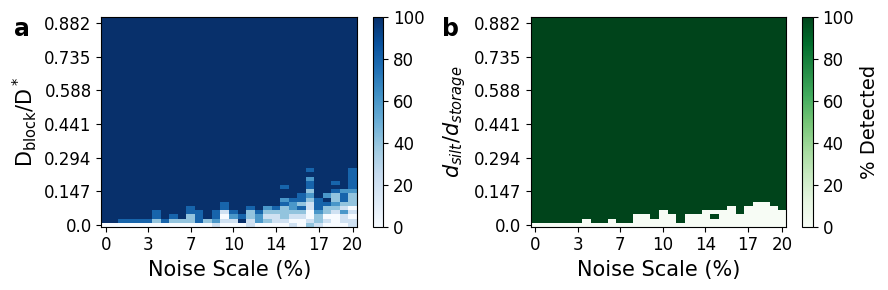

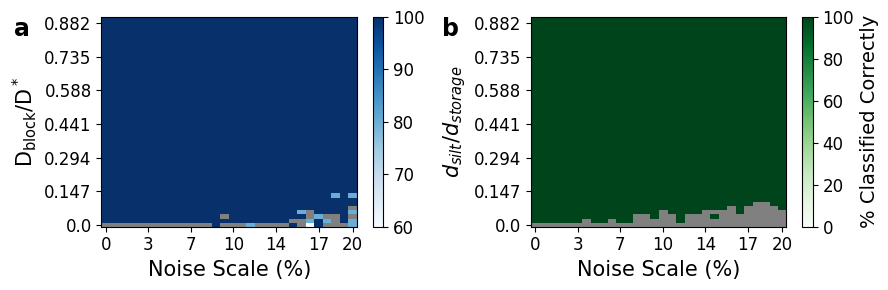

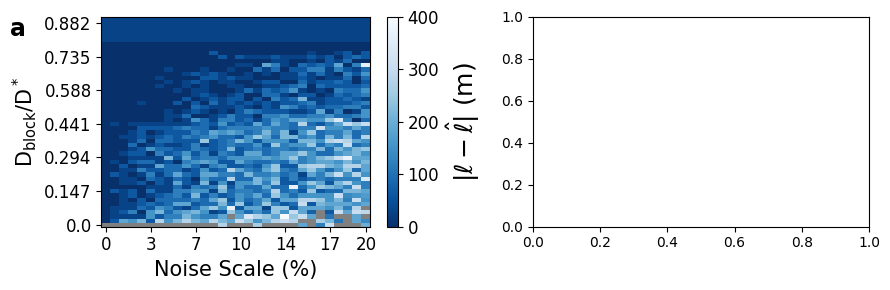

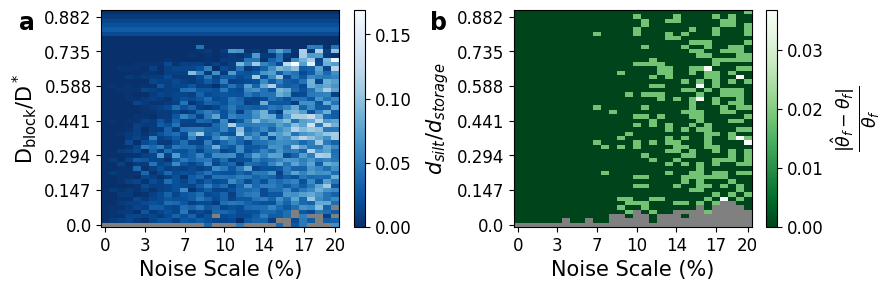

In [27]:
fault_types = ['diameter', 'silting']
error_types = ['detection', 'classification', 'localization', 'characterization']
for error_type in error_types:
    if error_type == 'detection':
        cbar_label = '% Detected'
        cbar_fontsize = 14
        cmap_suffix = ''
        cbar_mult = 100
        vmax_round = 1
    elif error_type == 'classification':
        cbar_label = '% Classified Correctly'
        cbar_fontsize = 14
        cmap_suffix = ''
        cbar_mult = 100
        vmax_round = 1
    elif error_type == 'localization':
        cbar_label = '$|\ell - \\hat{\ell}|$ (m)'
        cbar_fontsize = 18
        cmap_suffix = '_r'
        cbar_mult = 0.3048 # Convert to meters.
        vmax_round = 1
    elif error_type == 'characterization':
        cbar_label = '$\\frac{|\\hat{\\theta}_f - \\theta_f|}{\\theta_f}$'
        cbar_fontsize = 18
        cmap_suffix = '_r'
        cbar_mult = 1
        vmax_round = 1
    elif error_type == 'scenario_order':
        cbar_label = 'Mean Scenario Order'
        cbar_fontsize = 18
        cmap_suffix = '_r'

    fig, axes = plt.subplots(1, 2, figsize=(9,3))
    for i, fault_type in enumerate(fault_types):

        if i == 1 and error_type == 'localization':
            continue
        # Fault type to plot.
    #     fault_type = 'roughness'

        # Colormap names.
        if fault_type == 'diameter':
            cmap_name = 'Blues' + cmap_suffix
            ylabel = '$\\rm D_{block} / D^*$'
            severities = severity_dict[fault_type]
            yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    #         cbar_ticks = [0, 1000, 2000, 3000]
        elif fault_type == 'roughness':
            cmap_name = 'Reds' + cmap_suffix
            ylabel = "$n_f \ / \ n^*$"
            severities = severity_dict[fault_type]# * 0.01 
            yticks = np.linspace(0.015, 0.06, 4)
    #         cbar_ticks = [0, 1000, 2000, 3000]
        elif fault_type == 'silting':
            cmap_name = 'Greens' + cmap_suffix
            ylabel = '$d_{silt} / d_{storage}$'
            severities = severity_dict[fault_type]
            yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
    #         cbar_ticks = [0, 2000, 4000, 6000, 8000]

        # Plotting array.
        plotting_ar = severity_density_dict[error_type][fault_type] * cbar_mult
        nrow, ncol = plotting_ar.shape

        # Plot as image.
        ax = axes[i]
        vmax = np.nanmax(plotting_ar)
        vmin = np.nanmin(plotting_ar)
        if vmax == vmin:
            vmax = cbar_mult
            vmin = 0
        print(error_type, fault_type)
        print(vmax, vmin)
        cmap = colormaps[cmap_name]
        cmap.set_bad(color='gray')   
        cf = ax.imshow(plotting_ar, cmap=cmap, origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
        cbar = fig.colorbar(cf, ax=ax)
        if i == 1 or error_type == 'localization':
            cbar.set_label(cbar_label, fontsize=cbar_fontsize)
        cbar.ax.tick_params(labelsize=12)
        cbar_ticks = cbar.get_ticks()
        # Format cbar ticks.
        if cbar_ticks[-1] != vmax:
            # cbar_ticks = np.append(cbar_ticks, cbar_ticks[-1] + (cbar_ticks[-1] - cbar_ticks[-2]))
            print('CBAR TICK', cbar_ticks)

        # cbar.set_ticks(np.append(cbar_ticks[:-1], total_length))
        ax.set_xlabel('Noise Scale (%)', fontsize=15)
        ax.set_ylabel(ylabel, fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
        # X-ticks.
        xtick_idx = np.arange(0, ncol, 1)
        xtick_labels = [round(nr) for nr in noise_scale * 100]
        ax.set_xticks(np.append(xtick_idx[::int(len(xtick_idx)/6)], xtick_idx[-1]))
        ax.set_xticklabels(xtick_labels[::int(len(xtick_idx)/6)] + [xtick_labels[-1]])
        # Y-ticks.
        ytick_idx = np.arange(0, nrow, 2)
        ax.set_yticks(ytick_idx[::int(len(ytick_idx)/6)])
        ax.set_yticklabels(np.round(severities[ytick_idx], 3)[::int(len(ytick_idx)/6)])
        
        # Add subfigure letter.
        halign=1
        subplot_labels = ['a', 'b', 'c']
        ax.text(-0.28, halign, subplot_labels[i],
            transform=ax.transAxes,  # Coordinates relative to the axis (0,0) to (1,1)
            fontsize=17,             # Font size
            verticalalignment='top', # Align text to the top
            horizontalalignment='right',  # Align text to the right
            weight='bold')
    
    fig.tight_layout()
    fig.savefig(fig_savefp / f'single_{error_type}_accuracy.png', dpi=300)

### Flood severity estimation

In [24]:
# Load in flooding data frame.
flood_df_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_2.5yr_fault_database.csv"
flood_df = pd.read_csv(flood_df_fp)

In [72]:
print(flood_df['datetime'].iloc[:10])

0    2020-01-01 00:01:00
1    2020-01-01 00:02:00
2    2020-01-01 00:03:00
3    2020-01-01 00:04:00
4    2020-01-01 00:05:00
5    2020-01-01 00:06:00
6    2020-01-01 00:07:00
7    2020-01-01 00:08:00
8    2020-01-01 00:09:00
9    2020-01-01 00:10:00
Name: datetime, dtype: object


In [25]:
V_ar = np.zeros((len(severity_dict['diameter']), len(noise_scale)))
fault_components = [76, 77, 78, 79, 80]
# fault_components = [20]

for i, severity in enumerate(severity_dict['diameter']):
    print(i)
    for j, noise_scale_idx in enumerate(noise_scale):
        component_volumes = []
        for l, fault_component in enumerate(fault_components):
            noise_scale_idx = j 
            true_fault_type = 'diameter'
            true_fault_component = fault_component
            true_fault_severity_index = i
            true_fault_severity = severity_dict[true_fault_type][true_fault_severity_index]
            # print('Fault Severity:', fault_severity)
            # print('Noise:', '{:0.2f}%'.format(noise_scale[noise_scale_idx] * 100))
            experiment_df = diagnosis_df.loc[(diagnosis_df['true_fault_type']==true_fault_type) & 
                                             (diagnosis_df['true_fault_component']==true_fault_component) & 
                                             (diagnosis_df['true_fault_value']==true_fault_severity) & 
                                             (diagnosis_df['noise_level']==noise_scale[noise_scale_idx]), :].reset_index(drop=True)
            # Select data out of diagnosis df.
            # experiment_df = diagnosis_df.loc[diagnosis_df['experiment']==experiment, :].reset_index(drop=True)
            # print(experiment_df.head(10))

            # Array to store flooding at each node.
            flood_nodes = [18, 17, 20, 15, 2]
            flood_volume = np.zeros(len(flood_nodes))

            # # Loop through rows and get the flooding for each test sample diagnosis.
            # for i in range(experiment_df.shape[0]):
            #     # Predicted fault type, component, and value from diagnosis.
            #     fault_type = experiment_df['predict_fault_type'].iloc[i]
            #     fault_component = experiment_df['predict_fault_component'].iloc[i]
            #     fault_value = experiment_df['predict_fault_value'].iloc[i]
            #     for j, node in enumerate(flood_nodes):
            #         # Total flooding at each node from that diagnosis.
            #         node_flooding = flood_df.loc[(flood_df['fault_type']==fault_type) & (flood_df['fault_component']==fault_component) & (flood_df['fault_value']==fault_value), f'Flood_node_{node}']
            #         V_flood = np.trapz(node_flooding, dx=60) * 0.028316847 # cfs to m^3/s
            #         flood_volume[i,j] = V_flood

            # Predicted fault type, component, and value from diagnosis.
            fault_type = experiment_df['ens_predict_fault_type'].iloc[0]
            fault_component = experiment_df['ens_predict_fault_component'].iloc[0]
            fault_value = experiment_df['ens_predict_fault_value'].iloc[0]
            # print(fault_type, fault_component, fault_value)
            # print(true_fault_type, true_fault_component, true_fault_severity)
            for k, node in enumerate(flood_nodes):
                # Total flooding at each node from that diagnosis.
                true_node_flooding = flood_df.loc[(flood_df['fault_type']==true_fault_type) & 
                                                  (flood_df['fault_component']==true_fault_component) & 
                                                  (flood_df['fault_value']==true_fault_severity), f'Flood_node_{node}']
                pred_node_flooding = flood_df.loc[(flood_df['fault_type']==fault_type) & 
                                                  (flood_df['fault_component']==fault_component) & 
                                                  (flood_df['fault_value']==fault_value), f'Flood_node_{node}']

                true_V_flood = np.trapz(true_node_flooding, dx=60) * 0.028316847 # cfs to m^3/s
                pred_V_flood = np.trapz(pred_node_flooding, dx=60) * 0.028316847 # cfs to m^3/s
                flood_volume[k] = pred_V_flood - true_V_flood

            component_volumes.append(np.sum(flood_volume))
            # break
            
        V_ar[i,j] = np.sum(component_volumes) / len(fault_components)
    #     break
    # break

        # print("TRUE: {}, {}, {}".format(experiment_df['true_fault_type'].iloc[0], 
        #                                 experiment_df['true_fault_component'].iloc[0], 
        #                                 experiment_df['true_fault_value'].iloc[0]))
        # print("TRUE: {}, {}, {}".format(experiment_df['ens_predict_fault_type'].iloc[0], 
        #                                 experiment_df['ens_predict_fault_component'].iloc[0], 
        #                                 experiment_df['ens_predict_fault_value'].iloc[0]))
        # print('Max. flood volume:', np.max(flood_volume))


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


1.9947782684066204
1799.3933021996918


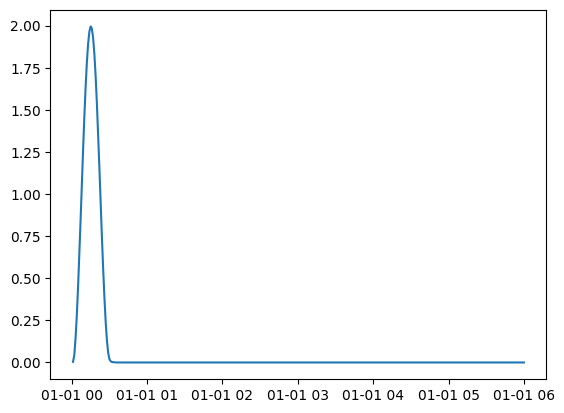

In [122]:
inflow_depth = phy_db.loc[(phy_db['scenario']==0), 'Depth_link_39']
inflow_velocity = phy_db.loc[(phy_db['scenario']==0), 'Velocity_link_39']
inflow_area = swmm.compute_area_from_depth(inflow_depth, 39)
inflow = inflow_velocity * inflow_area# * 0.028316847 # cfs to m^3/s
print(np.max(inflow))
print(np.trapz(inflow, dx=60))

fig, ax = plt.subplots()
ax.plot(phy_healthy_db['datetime'], inflow)

28.695998817724803


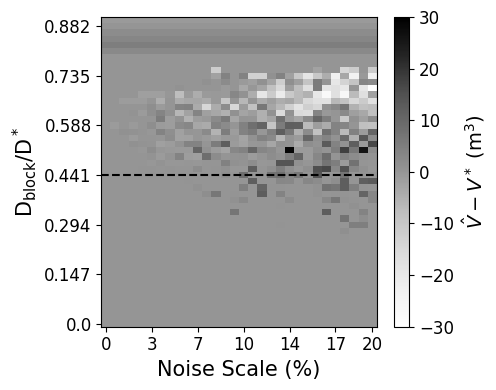

In [34]:
fig, ax = plt.subplots(figsize=(5,4))
cf = ax.imshow(V_ar, cmap='Greys', origin='lower', aspect='auto', vmin=-30, vmax=30)
ax.axhline(24, c='k', linestyle='--')
cbar = fig.colorbar(cf, ax=ax)
cbar.set_label('$\\hat{V} - V^*$ (m$^3$)', fontsize=14)
# cbar.set_label(cbar_label, fontsize=cbar_fontsize)
cbar.ax.tick_params(labelsize=12)

ax.set_xlabel('Noise Scale (%)', fontsize=15)
ylabel = '$\\rm D_{block} / D^*$'
# ylabel = '$d_{silt} / d_{storage}$'
ax.set_ylabel(ylabel, fontsize=15)
ax.tick_params(axis='both', labelsize=12)
# X-ticks.
xtick_idx = np.arange(0, ncol, 1)
xtick_labels = [round(nr) for nr in noise_scale * 100]
ax.set_xticks(np.append(xtick_idx[::int(len(xtick_idx)/6)], xtick_idx[-1]))
ax.set_xticklabels(xtick_labels[::int(len(xtick_idx)/6)] + [xtick_labels[-1]])
# Y-ticks.
ytick_idx = np.arange(0, nrow, 2)
ax.set_yticks(ytick_idx[::int(len(ytick_idx)/6)])
ax.set_yticklabels(np.round(severities[ytick_idx], 3)[::int(len(ytick_idx)/6)])

print(np.max(V_ar))

fig.tight_layout()
fig.savefig(fig_savefp / 'figure_10.png', dpi=300)

[[0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         5.22731743 0.        ]
 [0.         0.         0.         3.57867474 0.        ]
 [0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         9.43224823 0.        ]
 [0.         0.         0.         9.43224823 0.        ]]
[[       nan        nan        nan 9.43224823        nan]
 [       nan        nan        nan 9.43224823        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan 9.43224823        nan]
 [       nan        nan        nan 5.22731743        nan]
 [       nan        nan        nan 3.57867474        nan]
 [       nan        nan        nan 9.43224823        nan]
 [       nan 

C:\Users\ay434\AppData\Local\Temp\ipykernel_1332\480563677.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1, 3, 5, 7, 9])


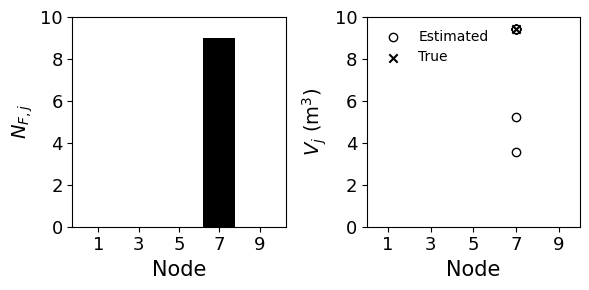

In [476]:
# Boxplot of flooding.
print(flood_volume)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(6,3))
# Number of test sample diagnoses predicting flooding at each location.
ax.bar([str(fn) for fn in flood_nodes], height=np.sum((flood_volume > 0), axis=0), facecolor='k')
ax.set_ylim([0, 10])
ax.set_xticklabels([1, 3, 5, 7, 9])
ax.tick_params(labelsize=13)
ax.set_xlabel('Node', fontsize=15)
ax.set_ylabel('$N_{F,j}$', fontsize=14)

# Flooding severity plot.
flood_volume_nan = flood_volume.copy()
flood_volume_nan[flood_volume_nan <= 0] = np.nan
print(flood_volume_nan)
for i, n in enumerate([1, 3, 5, 7, 9]):
    ax1.scatter(np.repeat(n, 10), flood_volume_nan[:,i], edgecolors='k', facecolor='w')
ax1.scatter([], [], edgecolors='k', facecolor='w', label='Estimated')
ax1.scatter(7, flood_volume[0,3], c='k', marker='x', label='True')
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 10)
ax1.set_xticks([1, 3, 5, 7, 9])
ax1.set_xticklabels([1, 3, 5, 7, 9])
ax1.tick_params(labelsize=13)
ax1.set_xlabel('Node', fontsize=15)
ax1.set_ylabel('$V_j \  \\rm (m^3)$', fontsize=14)
ax1.legend(frameon=False)

fig.tight_layout()
fig.savefig(fig_savefp / f'flood_estimation.png', dpi=300)


## Sensors and ensembling

In [332]:
# Aggregate accuracy metrics for increasing number of sensors.
# print('detection - diameter', np.nanmean(severity_density_dict['detection']['diameter']))
# print('detection - roughness', np.nanmean(severity_density_dict['detection']['roughness']))
# print('detection - silting', np.nanmean(severity_density_dict['detection']['silting']))
# print('classification - diameter', np.nanmean(severity_density_dict['classification']['diameter']))
# print('classification - roughness', np.nanmean(severity_density_dict['classification']['roughness']))
# print('classification - silting', np.nanmean(severity_density_dict['classification']['silting']))
# print('localization - diameter', np.nanmean(severity_density_dict['localization']['diameter']))
# print('localization - roughness', np.nanmean(severity_density_dict['localization']['roughness']))
# print('localization - silting', np.nanmean(severity_density_dict['localization']['silting']))
# print('characterization - diameter', np.nanmean(severity_density_dict['characterization']['diameter']))
# print('characterization - roughness', np.nanmean(severity_density_dict['characterization']['roughness']))
# print('characterization - silting', np.nanmean(severity_density_dict['characterization']['silting']))

print('detection {:.4f}, {:.4f}, {:.4f}'.format(np.nanmean(severity_density_dict['detection']['diameter']), np.nanmean(severity_density_dict['detection']['roughness']), 
      np.nanmean(severity_density_dict['detection']['silting'])))
print('classification {:.4f}, {:.4f}, {:.4f}'.format(np.nanmean(severity_density_dict['classification']['diameter']), np.nanmean(severity_density_dict['classification']['roughness']), 
      np.nanmean(severity_density_dict['classification']['silting'])))
print('localization {:.4f}, {:.4f}, {:.4f}'.format(np.nanmean(severity_density_dict['localization']['diameter']), np.nanmean(severity_density_dict['localization']['roughness']), 
      np.nanmean(severity_density_dict['localization']['silting'])))
print('characterization {:.4f}, {:.4f}, {:.4f}'.format(np.nanmean(severity_density_dict['characterization']['diameter']), np.nanmean(severity_density_dict['characterization']['roughness']), 
      np.nanmean(severity_density_dict['characterization']['silting'])))


sensor_accuracy_dict = {
    'n_sensor': [1, 2, 3, 4],
    'detection': [(0.891666, 0.8699,  0.93166), (0.94883, 0.9195, 0.93083), (0.9842, 0.9442, 0.9525), (0.9765, 0.9391, 0.9550)],
    'classification': [(0.8549618, 0.93288, 0.998211), (0.922875, 0.9502, 0.99552), (0.9640, 0.9843, 0.9983), (0.9703, 0.9877, 0.9983)], 
    'localization': [(328.432, 171.158, 1.80679), (163.574, 103.552, 2.493), (56.1422, 44.5751, 1.1067), (17.9277, 23.4606, 0.8813)],
    'characterization': [(1.69196, 0.13098, 0.07030), (1.1315, 0.1075, 0.1047), (0.5565, 0.0431, 0.0555), (0.4409, 0.0355, 0.0551)]
}

ensemble_accuracy_dict = {
    'n_sample': [1, 2, 4, 8],
    'detection': [(0.891666, 0.8699,  0.93166), (0.8385, 0.8417, 0.8875), (0.8332, 0.8308, 0.8992), (0.8380, 0.8283, 0.8925)],
    'classification': [(0.8549618, 0.93288, 0.998211), (0.9083, 0.9588, 1.0000), (0.9502, 0.9756, 1.0000), (0.9687, 0.9875, 1.0000)], 
    'localization': [(328.432, 171.158, 1.80679), (263.3315, 117.8810, 0.0000), (208.6593, 76.4057, 0.0000), (174.8104, 52.5871, 0.0000)],
    'characterization': [(1.69196, 0.13098, 0.07030), (1.0723, 0.0941, 0.0331), (0.5651, 0.0585, 0.0232), (0.3611, 0.0349, 0.0142)]
}


detection 0.8385, 0.8417, 0.8875
classification 0.9083, 0.9588, 1.0000
localization 263.3315, 117.8810, 0.0000
characterization 1.0723, 0.0941, 0.0331


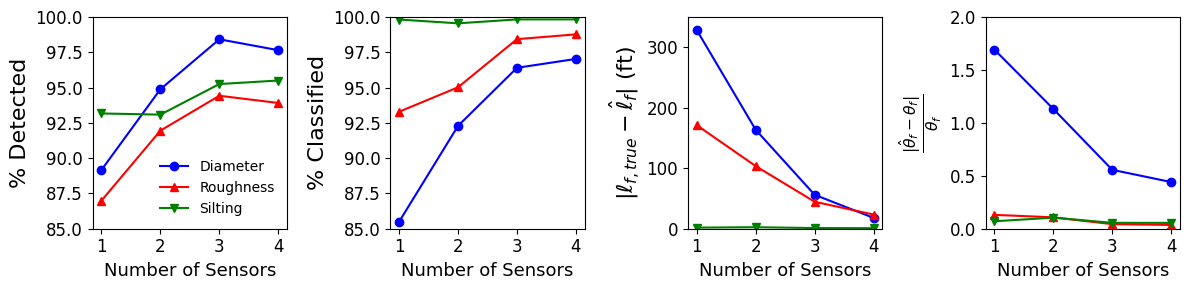

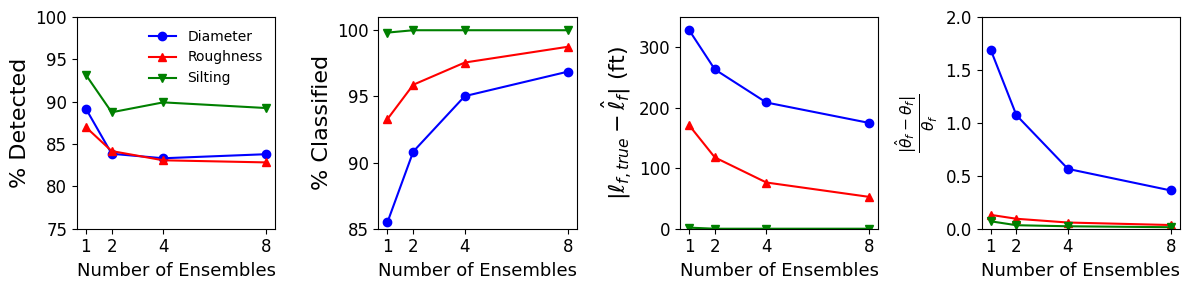

In [367]:
# Sensor accuracy plot.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
ax1.plot(sensor_accuracy_dict['n_sensor'], [tup[0]*100 for tup in sensor_accuracy_dict['detection']], 'b-o', label='Diameter')
ax1.plot(sensor_accuracy_dict['n_sensor'], [tup[1]*100 for tup in sensor_accuracy_dict['detection']], 'r-^', label='Roughness')
ax1.plot(sensor_accuracy_dict['n_sensor'], [tup[2]*100 for tup in sensor_accuracy_dict['detection']], 'g-v', label='Silting')
ax1.legend(frameon=False)
ax1.set_ylabel('% Detected', fontsize=16)
ax1.set_ylim([85, 100])

ax2.plot(sensor_accuracy_dict['n_sensor'], [tup[0]*100 for tup in sensor_accuracy_dict['classification']], 'b-o', label='Diameter')
ax2.plot(sensor_accuracy_dict['n_sensor'], [tup[1]*100 for tup in sensor_accuracy_dict['classification']], 'r-^', label='Roughness')
ax2.plot(sensor_accuracy_dict['n_sensor'], [tup[2]*100 for tup in sensor_accuracy_dict['classification']], 'g-v', label='Silting')
ax2.set_ylabel('% Classified', fontsize=16)
ax2.set_ylim([85, 100])

ax3.plot(sensor_accuracy_dict['n_sensor'], [tup[0] for tup in sensor_accuracy_dict['localization']], 'b-o', label='Diameter')
ax3.plot(sensor_accuracy_dict['n_sensor'], [tup[1] for tup in sensor_accuracy_dict['localization']], 'r-^', label='Roughness')
ax3.plot(sensor_accuracy_dict['n_sensor'], [tup[2] for tup in sensor_accuracy_dict['localization']], 'g-v', label='Silting')
ax3.set_ylabel('$|\ell_{f,true} - \\hat{\ell}_f|$ (ft)', fontsize=16)
ax3.set_ylim([0, 350])

ax4.plot(sensor_accuracy_dict['n_sensor'], [tup[0] for tup in sensor_accuracy_dict['characterization']], 'b-o', label='Diameter')
ax4.plot(sensor_accuracy_dict['n_sensor'], [tup[1] for tup in sensor_accuracy_dict['characterization']], 'r-^', label='Roughness')
ax4.plot(sensor_accuracy_dict['n_sensor'], [tup[2] for tup in sensor_accuracy_dict['characterization']], 'g-v', label='Silting')
ax4.set_ylabel('$\\frac{|\\hat{\\theta}_f - \\theta_f|}{\\theta_f}$', fontsize=16)
ax4.set_ylim([0, 2])

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Number of Sensors', fontsize=13)
    ax.set_xticks([1, 2, 3, 4])
    ax.tick_params(labelsize=12)

fig.tight_layout()
fig.savefig(fig_savefp / 'n_sensor_accuracy.png', dpi=300)

# Sensor accuracy plot.
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3))
ax1.plot(ensemble_accuracy_dict['n_sample'], [tup[0]*100 for tup in ensemble_accuracy_dict['detection']], 'b-o', label='Diameter')
ax1.plot(ensemble_accuracy_dict['n_sample'], [tup[1]*100 for tup in ensemble_accuracy_dict['detection']], 'r-^', label='Roughness')
ax1.plot(ensemble_accuracy_dict['n_sample'], [tup[2]*100 for tup in ensemble_accuracy_dict['detection']], 'g-v', label='Silting')
ax1.legend(frameon=False)
ax1.set_ylabel('% Detected', fontsize=16)
ax1.set_ylim([75, 100])

ax2.plot(ensemble_accuracy_dict['n_sample'], [tup[0]*100 for tup in ensemble_accuracy_dict['classification']], 'b-o', label='Diameter')
ax2.plot(ensemble_accuracy_dict['n_sample'], [tup[1]*100 for tup in ensemble_accuracy_dict['classification']], 'r-^', label='Roughness')
ax2.plot(ensemble_accuracy_dict['n_sample'], [tup[2]*100 for tup in ensemble_accuracy_dict['classification']], 'g-v', label='Silting')
ax2.set_ylabel('% Classified', fontsize=16)
ax2.set_ylim([85, 101])

ax3.plot(ensemble_accuracy_dict['n_sample'], [tup[0] for tup in ensemble_accuracy_dict['localization']], 'b-o', label='Diameter')
ax3.plot(ensemble_accuracy_dict['n_sample'], [tup[1] for tup in ensemble_accuracy_dict['localization']], 'r-^', label='Roughness')
ax3.plot(ensemble_accuracy_dict['n_sample'], [tup[2] for tup in ensemble_accuracy_dict['localization']], 'g-v', label='Silting')
ax3.set_ylabel('$|\ell_{f,true} - \\hat{\ell}_f|$ (ft)', fontsize=16)
ax3.set_ylim([0, 350])

ax4.plot(ensemble_accuracy_dict['n_sample'], [tup[0] for tup in ensemble_accuracy_dict['characterization']], 'b-o', label='Diameter')
ax4.plot(ensemble_accuracy_dict['n_sample'], [tup[1] for tup in ensemble_accuracy_dict['characterization']], 'r-^', label='Roughness')
ax4.plot(ensemble_accuracy_dict['n_sample'], [tup[2] for tup in ensemble_accuracy_dict['characterization']], 'g-v', label='Silting')
ax4.set_ylabel('$\\frac{|\\hat{\\theta}_f - \\theta_f|}{\\theta_f}$', fontsize=16)
ax4.set_ylim([0, 2])

for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlabel('Number of Ensembles', fontsize=13)
    ax.set_xticks([1, 2, 4, 8])
    ax.tick_params(labelsize=12)

fig.tight_layout()
fig.savefig(fig_savefp / 'n_ensemble_accuracy.png', dpi=300)

In [ ]:
species = ("Diameter", "Roughness", "Silting")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

In [314]:
print(error_df.head())

# Arrays to store fault data.
diameter_fault_distance = np.unique(error_df.loc[error_df['fault_class']=='diameter', 'fault_distance'])
roughness_fault_distance = np.unique(error_df.loc[error_df['fault_class']=='roughness', 'fault_distance'])
silting_fault_distance = np.unique(error_df.loc[error_df['fault_class']=='silting', 'fault_distance'])
fault_array_dict = {
    'diameter': np.zeros((len(severity_dict['diameter']), len(noise_rel_error), len(diameter_fault_distance))), 
    'roughness': np.zeros((len(severity_dict['roughness']), len(noise_rel_error), len(roughness_fault_distance))),
    'silting': np.zeros((len(severity_dict['silting']), len(noise_rel_error), len(silting_fault_distance)))
}

full_error_dict = {
    'classification': copy.deepcopy(fault_array_dict),
    'localization': copy.deepcopy(fault_array_dict),
    'characterization': copy.deepcopy(fault_array_dict)
}

for i in range(error_df.shape[0]):
    fault_type = error_df.loc[i, 'fault_class']
    severity = error_df.loc[i, 'fault_severity']
    measurement_error = error_df.loc[i, 'measurement_error']
    fault_distance = error_df.loc[i, 'fault_distance']
    severity_idx = np.where(severity_dict[fault_type] == severity)[0][0]
    error_idx = np.where(noise_rel_error == measurement_error)[0][0]

    # Get the location index.
    if fault_type == 'diameter':
        location_idx = np.where(diameter_fault_distance == fault_distance)[0][0]
    elif fault_type == 'roughness':
        location_idx = np.where(roughness_fault_distance == fault_distance)[0][0]
    elif fault_type == 'silting':
        location_idx = np.where(silting_fault_distance == fault_distance)[0][0]
    
    full_error_dict['classification'][fault_type][severity_idx, error_idx, location_idx] = error_df.loc[i, 'class_error']
    full_error_dict['localization'][fault_type][severity_idx, error_idx, location_idx] = error_df.loc[i, 'location_error']
    full_error_dict['characterization'][fault_type][severity_idx, error_idx, location_idx] = error_df.loc[i, 'severity_error']
    # severity_density_dict['classification'][fault_type][severity_idx, error_idx] = np.max(group['l2_norm'])
    # severity_density_dict['localization'][fault_type][severity_idx, error_idx] = np.max(group['l2_norm'])
    # severity_density_dict['characterization'][fault_type][severity_idx, error_idx] = np.max(group['l2_norm'])

print(full_error_dict['classification']['silting'][0,:])

  fault_class  fault_location  fault_distance  fault_severity   
0    diameter              76             5.0        0.100000  \
1    diameter              76             5.0        0.120513   
2    diameter              76             5.0        0.141026   
3    diameter              76             5.0        0.161538   
4    diameter              76             5.0        0.182051   

   measurement_error  scenario  predicted_scenario  class_error   
0                0.0         0                   0         True  \
1                0.0         1                   1         True   
2                0.0         2                   2         True   
3                0.0         3                   3         True   
4                0.0         4                   4         True   

   location_error  severity_error  predict_location   l2_norm  
0             0.0             0.0                76  0.013030  
1             0.0             0.0                76  0.012353  
2             

### Plot the relationship between diagnosis accuracy and distance from sensor

C:\Users\ay434\AppData\Local\Temp\ipykernel_23676\495792114.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')  # 'viridis' is just an example, can be changed
C:\Users\ay434\AppData\Local\Temp\ipykernel_23676\495792114.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Third Vector Value')


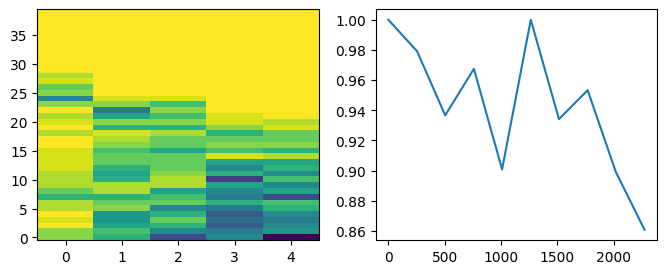

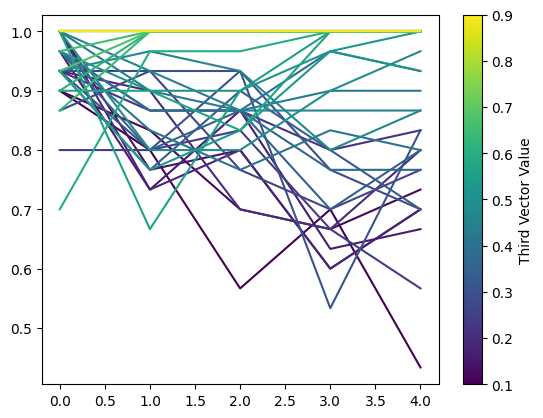

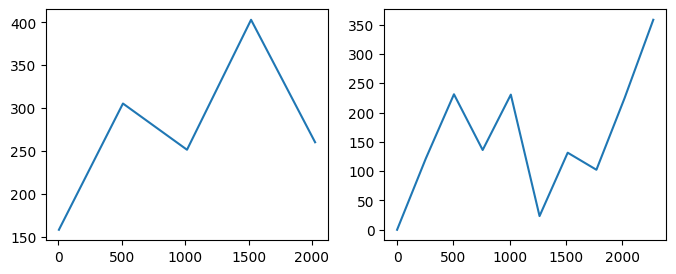

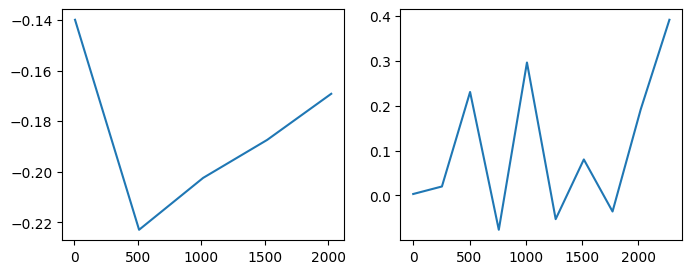

In [349]:
diameter_loc_classification = np.mean(full_error_dict['classification']['diameter'], axis=(1))
roughness_loc_classification = np.mean(full_error_dict['classification']['roughness'], axis=(0,1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.imshow(diameter_loc_classification, origin='lower', aspect='auto')
ax2.plot(roughness_fault_distance, roughness_loc_classification)

# Create a color map (you can use different colormaps from cm module)
from matplotlib import cm
cmap = cm.get_cmap('viridis')  # 'viridis' is just an example, can be changed

# Normalize third_vector to a range between 0 and 1 for color mapping
norm = plt.Normalize(vmin=np.min(severity_dict['diameter']), vmax=np.max(severity_dict['diameter']))

# Create figure and axis
fig, ax = plt.subplots()

# Loop through and plot each of the 40 lines
for i in range(diameter_loc_classification.T.shape[1]):
    ax.plot(diameter_loc_classification.T[:, i], color=cmap(norm(severity_dict['diameter'][i])))

# Optional: Add colorbar to indicate how colors correspond to third_vector
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Third Vector Value')

diameter_loc_localization = np.mean(full_error_dict['localization']['diameter'], axis=(0,1))
roughness_loc_localization = np.mean(full_error_dict['localization']['roughness'], axis=(0,1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(diameter_fault_distance, diameter_loc_localization)
ax2.plot(roughness_fault_distance, roughness_loc_localization)

diameter_loc_characterization = np.mean(full_error_dict['characterization']['diameter'], axis=(0,1))
roughness_loc_characterization = np.mean(full_error_dict['characterization']['roughness'], axis=(0,1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
ax1.plot(diameter_fault_distance, diameter_loc_characterization)
ax2.plot(roughness_fault_distance, roughness_loc_characterization)

# fig, ax = plt.subplots()
# for i in range(full_error_dict['localization']['roughness'].shape[0]):
#     for j in range(full_error_dict['localization']['roughness'].shape[1]):
#         ax.scatter(roughness_fault_distance, full_error_dict['localization']['roughness'][i,j,:], c='b', alpha=0.1)